### Cleaning and feature selection

In [1]:
# Warnings are provided to warn the developer of situations that aren’t necessarily exceptions. 
#Usually, a warning occurs when there is some obsolete of certain programming elements.
#Python program terminates immediately if an error occurs. Conversely, a warning is not critical.

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
kick_data = pd.read_csv('ConcatenatedResults/concatenated_results_kick.csv')

normal_data = pd.read_csv('ConcatenatedResults/concatenated_results_normal.csv')

validation_data = pd.read_csv('ConcatenatedResults/results_influx_validation_2023-03-27_12-48-45.csv')

df_validation = validation_data

In [4]:
print("NaN values in normal_data:", normal_data.isnull().sum().sum())
print("NaN values in kick_data:", kick_data.isnull().sum().sum())


NaN values in normal_data: 0
NaN values in kick_data: 0


In [5]:
kick_data.nunique()

SPP                             110270
DownholeECD                     110334
FlowRateOut                     110366
HookLoad                        110395
SurfaceTorque                   110539
BitDepth                         62602
ChokeOpening                         1
DownholePressure                110334
ChokePressure                        1
FluidTemperatureOut             110381
WOB                              62602
InstantaneousROP                 47086
BopChokeOpening                      1
FlowRateIn                         208
TopOfStringVelocity                 20
SurfaceRPM                         148
ChokePumpFlowRateIn                  1
TotalInfluxMass                  11801
CalculatedPressureBottomHole    110334
FluidTemperatureIn               79861
TotalMudLossMass                     1
TopOfStringPosition                600
ActivePitVolume                 108600
ActivePitDensity                 79739
ActivePitTemperature             79861
MainPitVolume            

### Removing constant columns

In [6]:
# Drop columns with non-float64 or non-int64 data type
df_validation = df_validation.select_dtypes(include=['float64', 'int64'])

In [7]:
def remove_unique_columns(df):
    for column in df.columns:
        if column not in ['GasFlowRateOut', 'TotalInfluxMass'] and df[column].nunique() == 1:
            df = df.drop(column, axis=1)
    return df

# Remove unique columns from df_train
kick_data = remove_unique_columns(kick_data)

# Remove unique columns from normal_data, except gasflowrateout and totalinfluxmass
normal_data = remove_unique_columns(normal_data)

# Remove unique columns from df_validation
df_validation = remove_unique_columns(df_validation)

### Random Sampling Split into 70/10/20

In [8]:
# Perform stratified train/test splits for both datasets
kick_train_val, kick_test = train_test_split(kick_data, test_size=0.2, stratify=kick_data['sim_ID'], random_state=42)
normal_train_val, normal_test = train_test_split(normal_data, test_size=0.2, stratify=normal_data['sim_ID'], random_state=42)

# Perform stratified train/validation splits for both datasets
kick_train, kick_val = train_test_split(kick_train_val, test_size=0.25, stratify=kick_train_val['sim_ID'], random_state=42)
normal_train, normal_val = train_test_split(normal_train_val, test_size=0.25, stratify=normal_train_val['sim_ID'], random_state=42)

# Concatenate the training, validation, and test sets
train_data = pd.concat([kick_train, normal_train], ignore_index=True)
val_data = pd.concat([kick_val, normal_val], ignore_index=True)
test_data = pd.concat([kick_test, normal_test], ignore_index=True)

# Shuffle the concatenated training, validation, and test sets
df_train = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
df_val = val_data.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
df_train = df_train.drop(['sim_ID'], axis=1)
df_val = df_val.drop(['sim_ID'], axis=1)
df_test = df_test.drop(['sim_ID'], axis=1)

### Scaling using the MinMaxScaler before Heatmap

In [10]:
# Initialize the scalers
minmax_scaler = MinMaxScaler()

# Fit and transform the data using both scalers
minmax_scaled_data = minmax_scaler.fit_transform(df_train)

# Create DataFrames with the scaled data
minmax_scaled_df = pd.DataFrame(minmax_scaled_data, columns=df_train.columns)

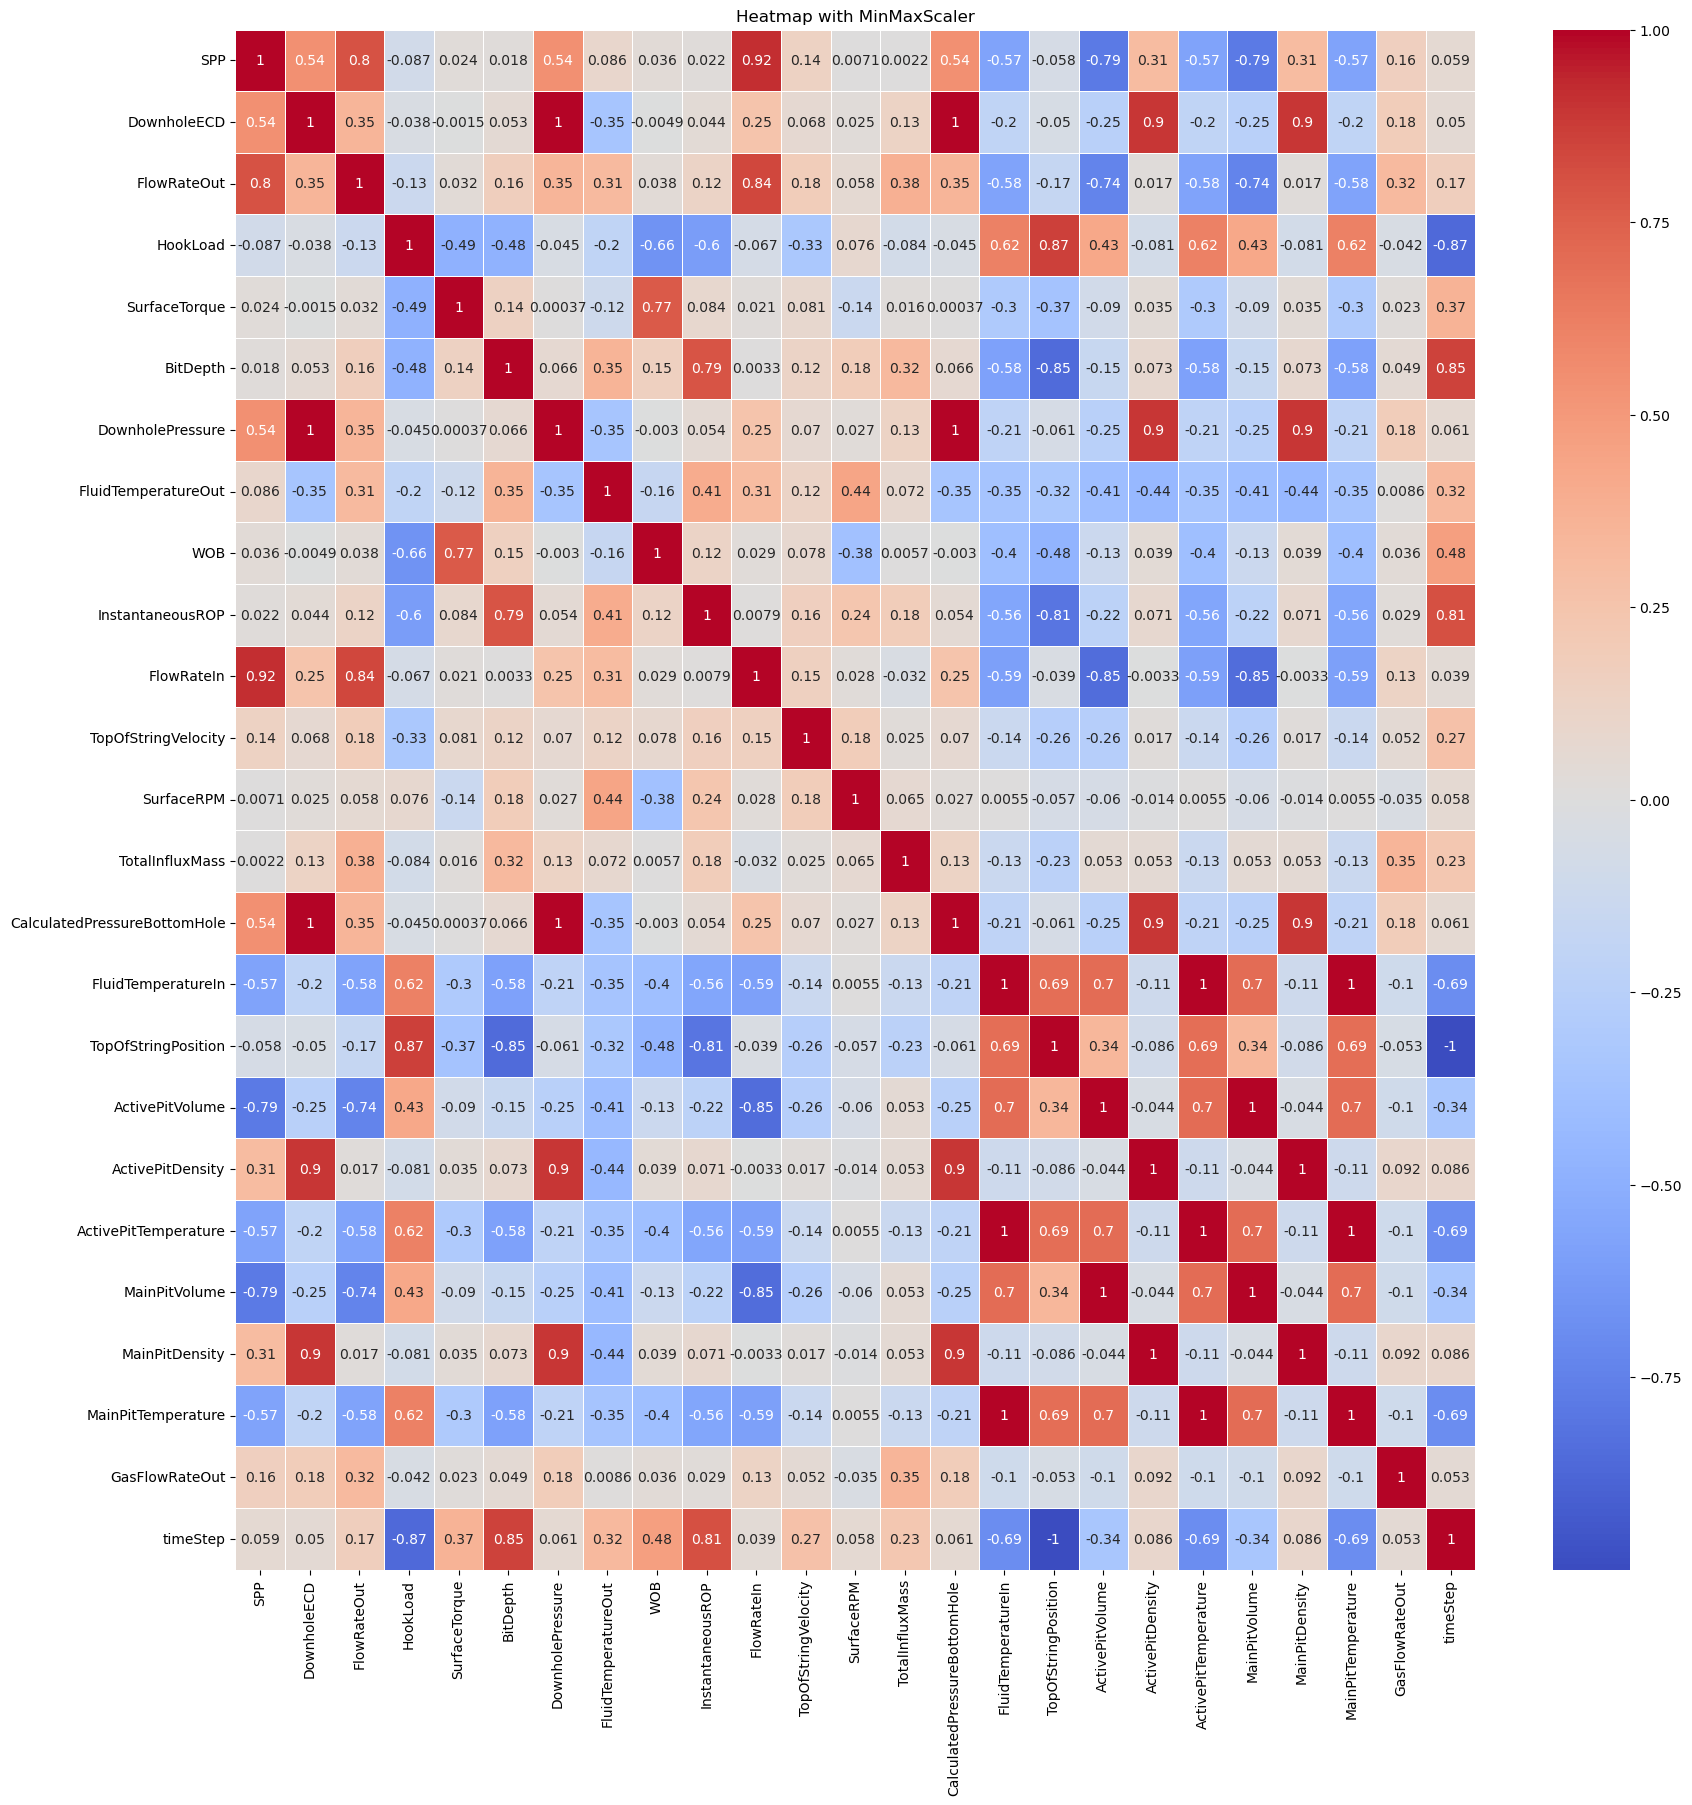

In [11]:
# Plot the heatmap for MinMaxScaler
plt.figure(figsize=(20, 20))
plt.title("Heatmap with MinMaxScaler")
sns.heatmap(minmax_scaled_df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()

### Removing features which are not relevant

In [12]:
# Assuming 'unwanted_features' is a list of column names you want to drop after feature selection
unwanted_features = ['GasFlowRateOut', 'TotalInfluxMass', 'TopOfStringPosition', 'MainPitTemperature', 'ActivePitVolume', 'ActivePitTemperature', 'ActivePitDensity', 'CalculatedPressureBottomHole', 'DownholeECD', 'TopOfStringVelocity']

# Unscaled the data using inverse_transform
unscaled_data = minmax_scaler.inverse_transform(minmax_scaled_df)

# Create a DataFrame with the unscaled data
unscaled_df = pd.DataFrame(unscaled_data, columns=df_train.columns)

# Drop the unwanted features
selected_features_df = unscaled_df.drop(columns=unwanted_features)

minmax_scaled_data_selected = minmax_scaler.fit_transform(selected_features_df)

# Create a DataFrame with the selected and scaled data
minmax_scaled_df_selected = pd.DataFrame(minmax_scaled_data_selected, columns=selected_features_df.columns)

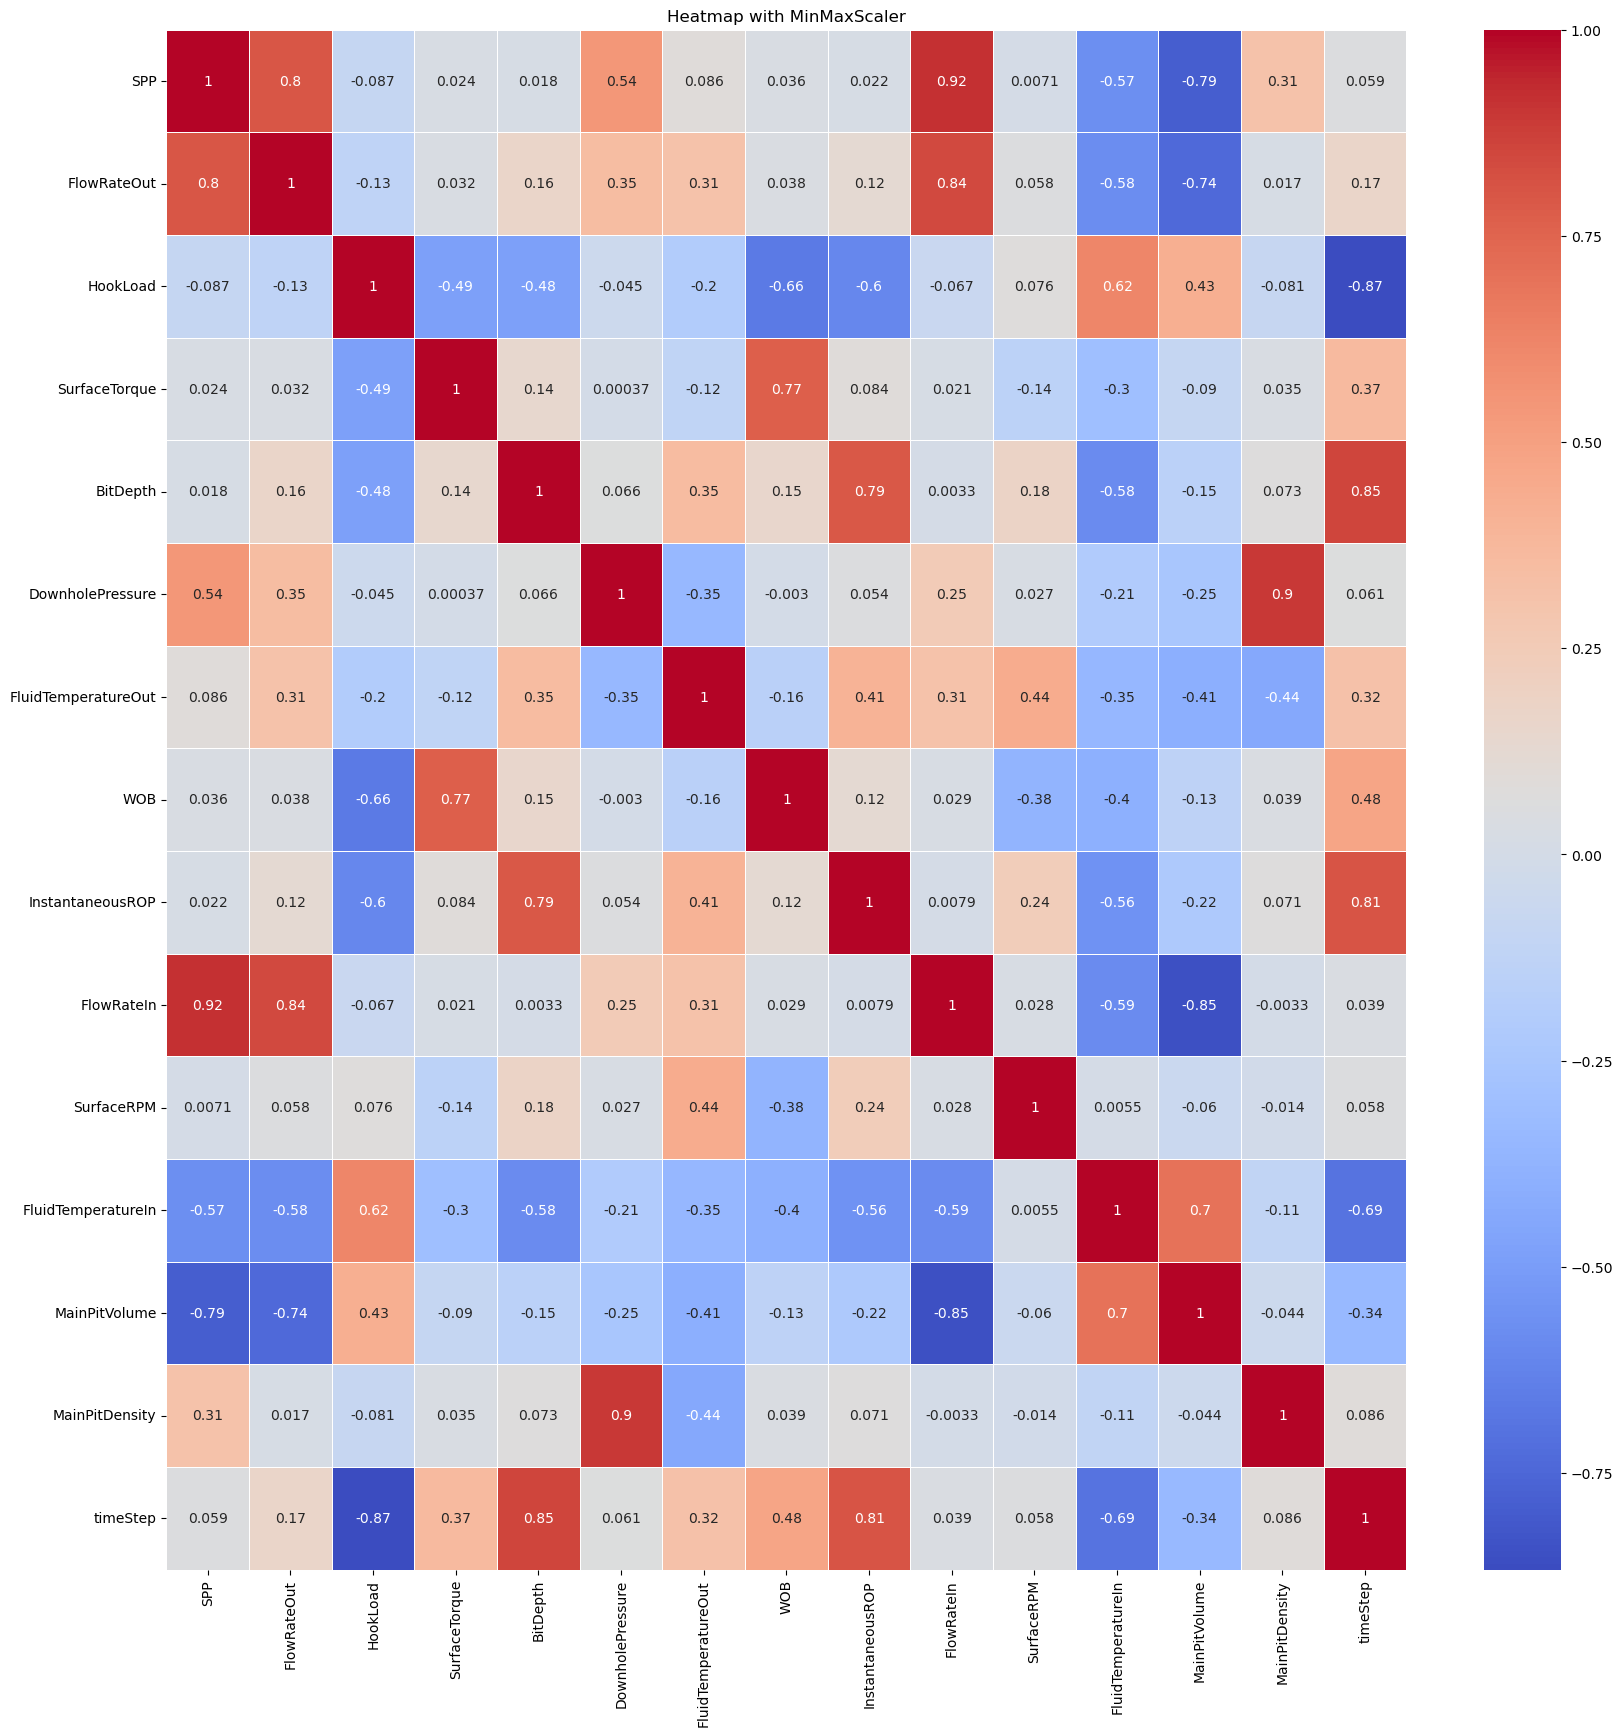

In [13]:
# Plot the heatmap for MinMaxScaler
plt.figure(figsize=(20, 20))
plt.title("Heatmap with MinMaxScaler")
sns.heatmap(minmax_scaled_df_selected.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()

In [14]:
df_train = minmax_scaled_df_selected

### Removing unwanted features and scaling the other dataframes aswell

In [15]:
df_vali = df_validation.drop(columns=unwanted_features)

scaled_data_validation = minmax_scaler.fit_transform(df_vali)

scaled_data_validation = pd.DataFrame(scaled_data_validation, columns=df_vali.columns)

df_validation = scaled_data_validation

In [16]:
# Drop the unwanted columns from df_test, excluding the 'TopOfStringVelocity' column
df_test1 = df_test.drop(columns=[col for col in unwanted_features])

# Scale the remaining columns using MinMaxScaler
scaled_data_test = minmax_scaler.fit_transform(df_test1)

# Create a new dataframe from the scaled data and use the column names from df_test1
scaled_data_test = pd.DataFrame(scaled_data_test, columns=df_test1.columns)

# Assign the new dataframe to df_test
df_test = scaled_data_test

In [17]:
# Drop the unwanted columns from df_test, excluding the 'TopOfStringVelocity' column
df_val1 = df_val.drop(columns=[col for col in unwanted_features])

# Scale the remaining columns using MinMaxScaler
scaled_data_val = minmax_scaler.fit_transform(df_val1)

# Create a new dataframe from the scaled data and use the column names from df_test1
scaled_data_val = pd.DataFrame(scaled_data_val, columns=df_val1.columns)

# Assign the new dataframe to df_test
df_val = scaled_data_val

### Storing the datasets, scaler and input/target column in the notebook for further ML in anoter notebook

In [18]:
# Store the DataFrame in the IPython database
%store df_train
%store df_val
%store df_test
%store df_validation

Stored 'df_train' (DataFrame)
Stored 'df_val' (DataFrame)
Stored 'df_test' (DataFrame)
Stored 'df_validation' (DataFrame)


In [19]:
# create a list of column names to include in the new DataFrame
input_col = [col for col in df_train.columns if col != 'DownholePressure']

target_col = ['DownholePressure']

%store input_col
%store target_col

Stored 'input_col' (list)
Stored 'target_col' (list)


In [20]:
%store minmax_scaler

Stored 'minmax_scaler' (MinMaxScaler)


In [21]:
# Split df_train into x_train and y_train
x_train = df_train[input_col]
y_train = df_train[target_col]

# Split the val data
x_val = df_val[input_col]
y_val = df_val[target_col]

# Split the testing data
x_test = df_test[input_col]
y_test = df_test[target_col]

#Split the validation data
x_validation = df_validation[input_col]
y_validation = df_validation[target_col]

### Plots to see how the features look against timesteps for split method 1

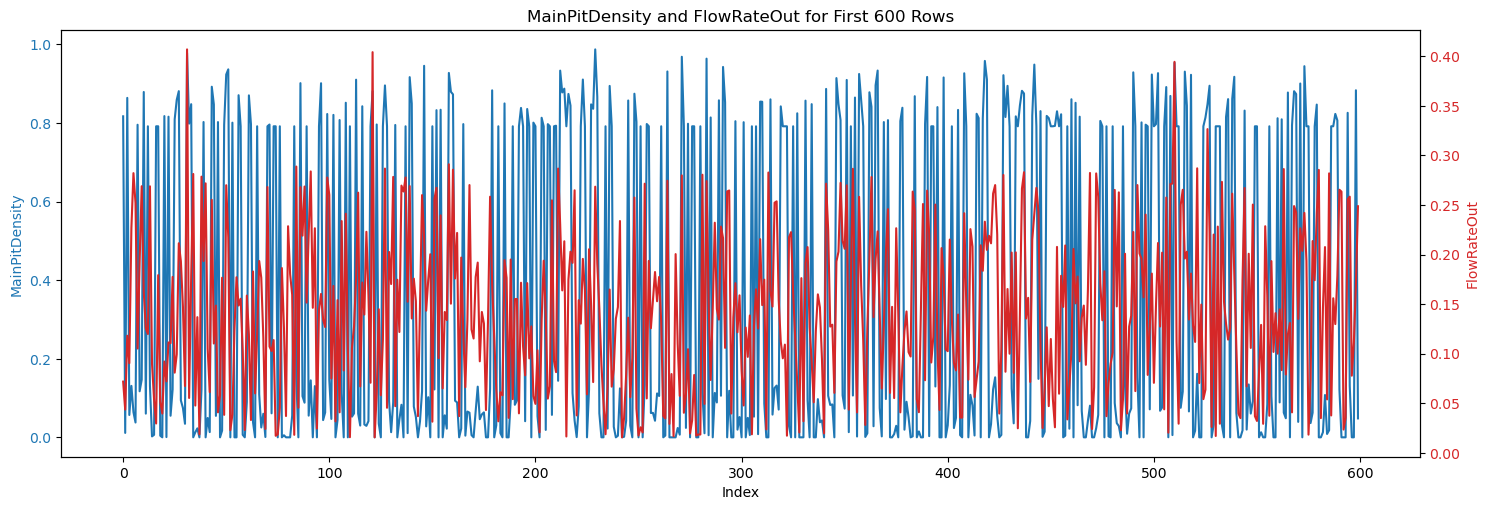

In [22]:
import matplotlib.pyplot as plt

# Assuming df_train is your train_data DataFrame
df_plot = df_train.head(600)

fig, ax1 = plt.subplots(figsize=(15, 5))  # Adjust the figsize here (width, height)

# Plot MainPitDensity with a blue color
color = 'tab:blue'
ax1.set_xlabel('Index')
ax1.set_ylabel('MainPitDensity', color=color)
ax1.plot(df_plot.index, df_plot['MainPitDensity'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot FlowRateOut with a red color
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('FlowRateOut', color=color)
ax2.plot(df_plot.index, df_plot['FlowRateOut'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('MainPitDensity and FlowRateOut for First 600 Rows')
plt.show()


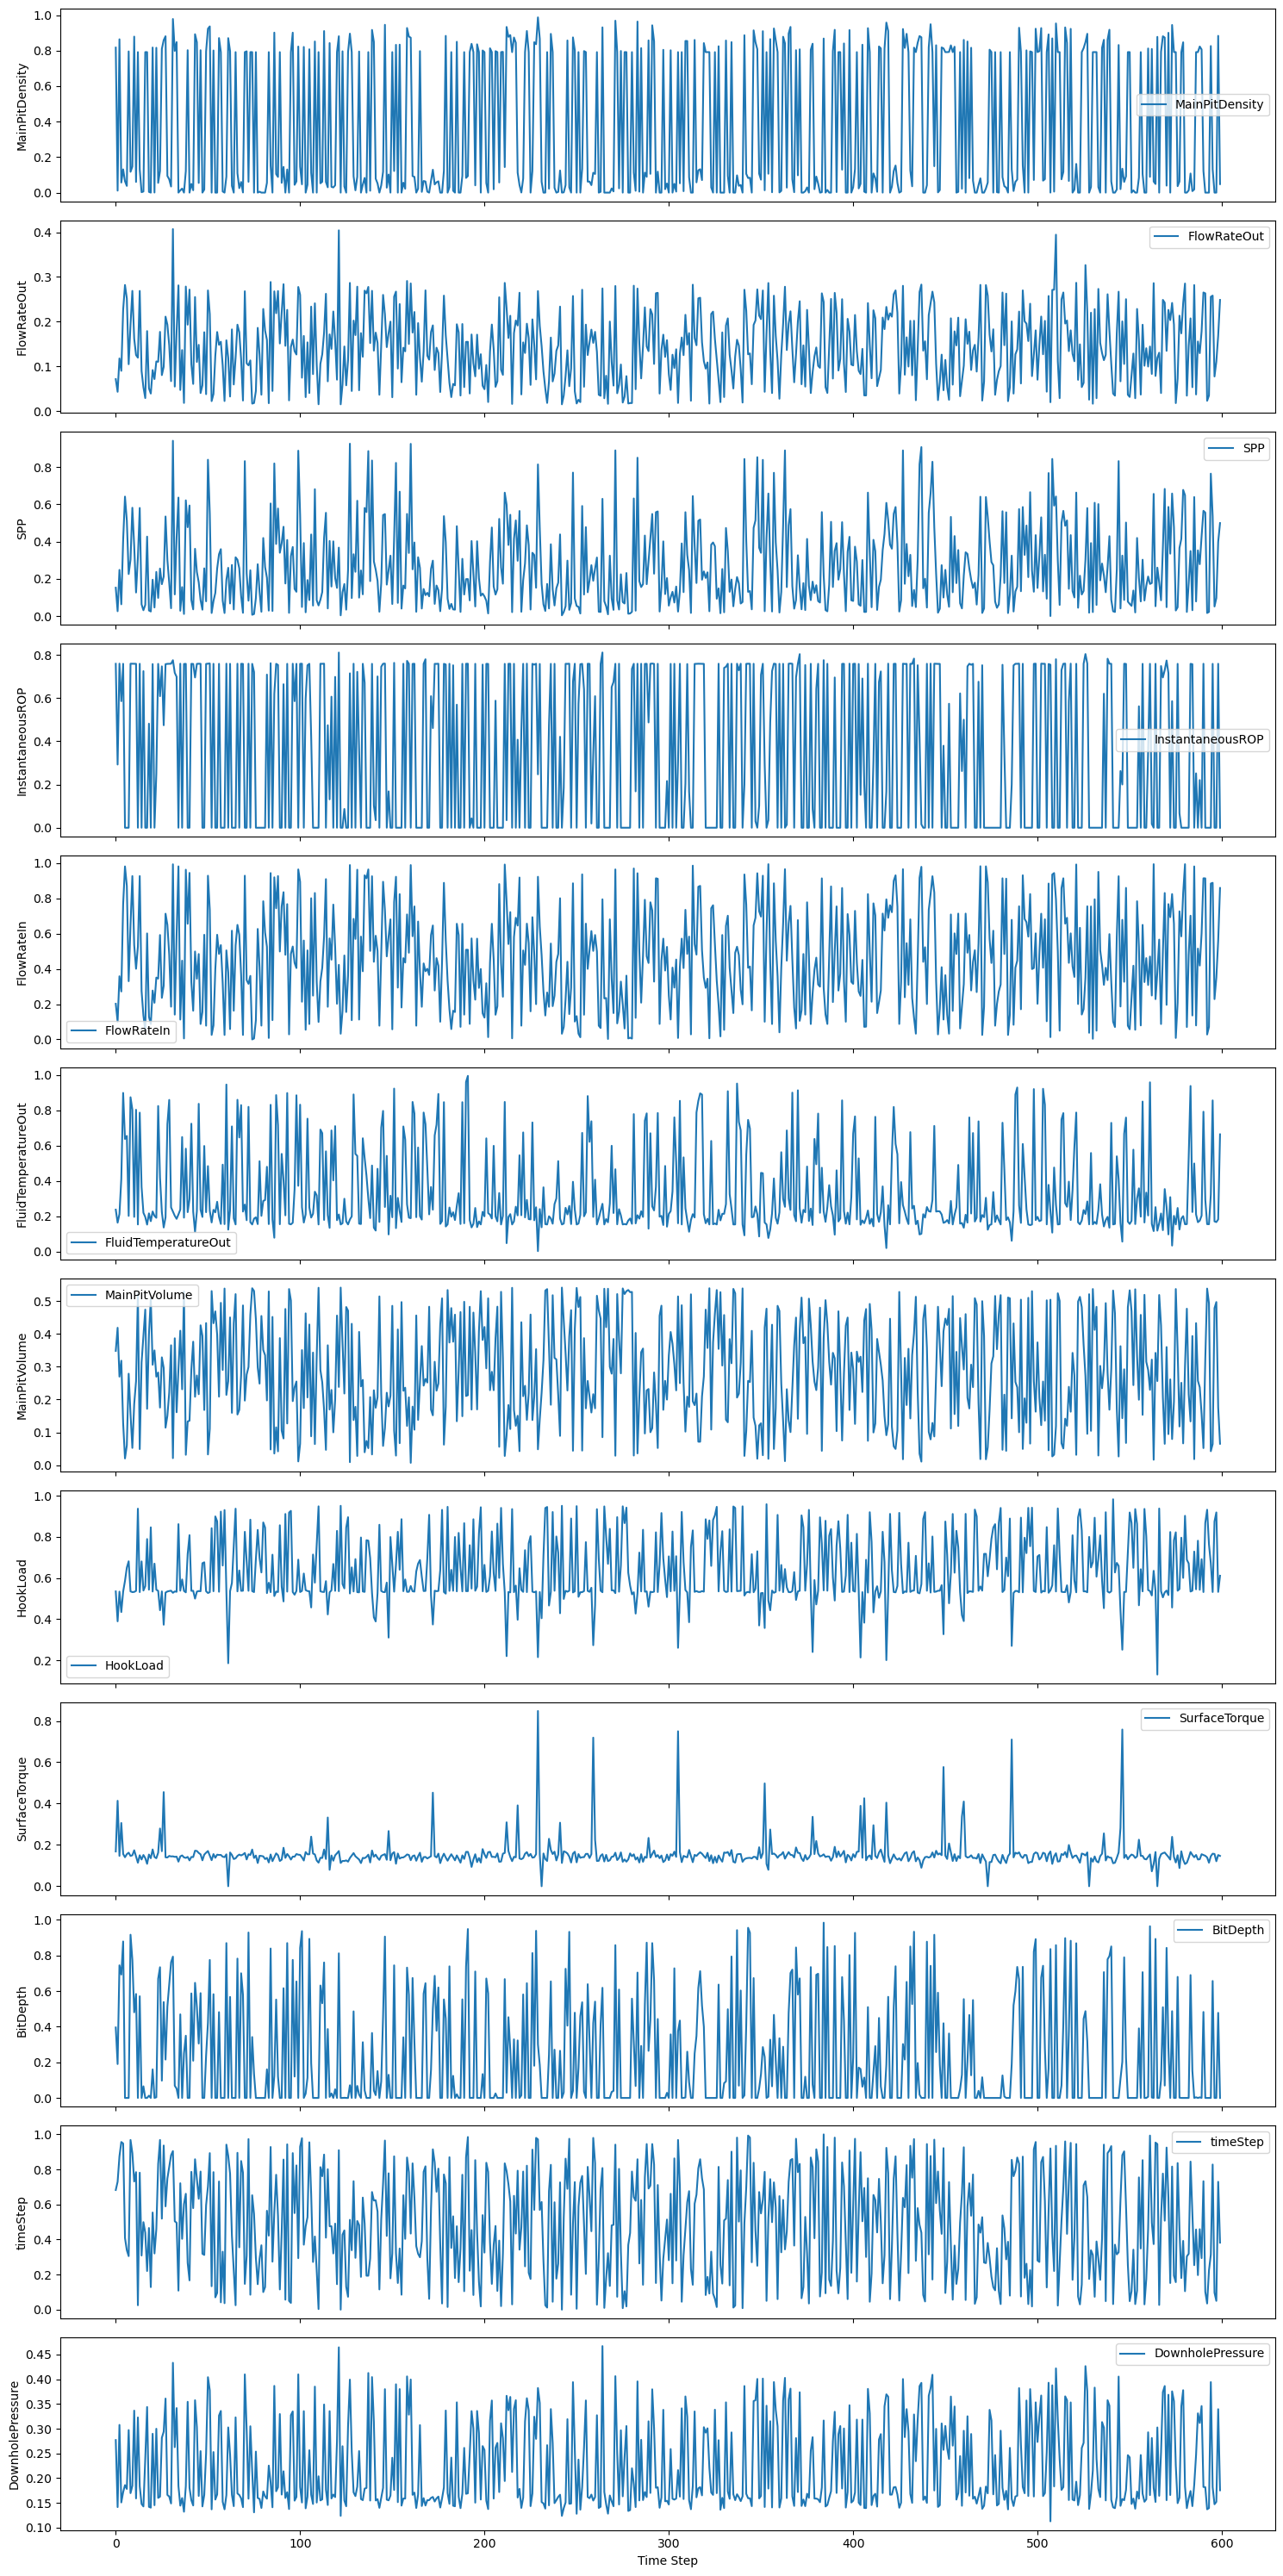

In [23]:
import matplotlib.pyplot as plt

features = [
    "MainPitDensity",
    "FlowRateOut",
    "SPP",
    "InstantaneousROP",
    "FlowRateIn",
    "FluidTemperatureOut",
    "MainPitVolume",
    "HookLoad",
    "SurfaceTorque",
    "BitDepth",
    "timeStep", 
    "DownholePressure"
]

# Assuming df_train is your training DataFrame
plot_data = df_train.head(600)

fig, axs = plt.subplots(len(features), figsize=(15, 30), sharex=True)

for i, feature in enumerate(features):
    axs[i].plot(plot_data[feature], label=feature)
    axs[i].set_ylabel(feature)
    axs[i].legend()

plt.xlabel('Time Step')
plt.tight_layout()
plt.show()
